# Importing the libraries

In [1]:
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow import keras
import platform
from tensorflow.keras import layers, optimizers, losses, models, Input, Model
import time # Per misurare il tempo di training
from tensorflow.keras.callbacks import EarlyStopping # Per l'early stopping
import matplotlib.pyplot as plt
from tqdm import tqdm # Per mostrare una barra di progresso
from tensorflow.keras.models import load_model

# Set seeds for random operations.

In [2]:
# --- 1. Impostazione del Seed Globale all'inizio del tuo script ---
# Questo è il punto chiave per la riproducibilità di TUTTO ciò che segue.
MASTER_RANDOM_SEED = 42
np.random.seed(MASTER_RANDOM_SEED)
random.seed(MASTER_RANDOM_SEED) # Imposta anche il seed per la libreria 'random' di Python se la usi
tf.random.set_seed(MASTER_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(MASTER_RANDOM_SEED) # Per operazioni basate su hash (es. ordine dei dizionari)
os.environ['TF_DETERMINISTIC_OPS'] = '1' # Forza operazioni deterministiche in TensorFlow 2.x

# Print the HW Specs.

In [3]:
print("--- Dettagli dell'Architettura Hardware della Sessione Colab ---\n")

# --- 1. Dettagli CPU ---
print("--- Dettagli CPU ---")
!lscpu
print("\n")

# --- 2. Dettagli RAM (Memoria) ---
print("--- Dettagli RAM (Memoria) ---")
!cat /proc/meminfo | grep MemTotal
print("\n")

# --- 3. Dettagli Spazio su Disco ---
print("--- Dettagli Spazio su Disco ---")
!df -h /
print("\n")

# --- 4. Dettagli Acceleratore Hardware (GPU/TPU) ---
print("--- Dettagli Acceleratore Hardware (GPU/TPU) ---")
try:
    tpu_address = os.environ.get('COLAB_TPU_ADDR')
    if tpu_address:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print(f"Tipo Acceleratore: TPU (indirizzo: {tpu_address})")
        print("Dispositivi TPU disponibili:")
        for device in tf.config.list_logical_devices('TPU'):
            print(f"  - {device.name}")
    else:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"Tipo Acceleratore: GPU")
            for gpu in gpus:
                print(f"  - Dispositivo GPU rilevato: {gpu.name}")
            print("\nDettagli GPU specifici (da `!nvidia-smi`):")
            !nvidia-smi
        else:
            print("Tipo Acceleratore: Nessuna GPU o TPU rilevata (in uso CPU)")

except Exception as e:
    print(f"Si è verificato un errore durante la rilevazione dell'acceleratore: {e}")
    print("Tentativo di rilevare i dispositivi TensorFlow standard:")
    devices = tf.config.list_logical_devices()
    if devices:
        for device in devices:
            print(f"  - Dispositivo rilevato: {device.name}, Tipo: {device.device_type}")
    else:
        print("Nessun dispositivo TensorFlow rilevato.")

print("\n--- Analisi Dettagli Hardware Completata ---")

--- Dettagli dell'Architettura Hardware della Sessione Colab ---

--- Dettagli CPU ---
Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4

# Connect To Gdrive to store the datasets created.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Function for calculating BER

In [10]:
# Funzione per calcolare il BER
# Il max_samples sono tutti i segnali per ogni punto SNR che ho attualmente nel test dataset.
def calculate_ber(model, snr_test_data_path, max_samples=500000):
    ber_values = []
    snr_points = list(range(0, 21))

    for snr_db in tqdm(snr_points, desc="Calculating BER"):
        test_file = os.path.join(snr_test_data_path, f"test_{snr_db}_SNR.npz")
        if not os.path.exists(test_file):
            print(f"File non trovato: {test_file}. Salto questo SNR.")
            ber_values.append(np.nan)
            continue

        data = np.load(test_file)
        X_batch, y_true_batch = data['X_test'], data['y_test']
        symbols_in_batch = X_batch.shape[0]

        if symbols_in_batch == 0:
            ber_values.append(np.nan)
            continue

         # --- Estrazione casuale di un sottoinsieme per prove ed esperimenti ---
        if len(X_batch) > max_samples:
            print("Entrato nell'if di riduzione samples nel test set per esperimenti veloci.")
            idx = np.random.choice(len(X_batch), max_samples, replace=False)
            X_batch = X_batch[idx]
            y_true_batch = y_true_batch[idx]

        predictions = model.predict(X_batch, batch_size=10000, verbose=0)
        predicted_labels = np.argmax(predictions, axis=1)
        errors = np.sum(predicted_labels != y_true_batch)
        ber = errors / symbols_in_batch
        ber_values.append(ber)
        print(f"SNR: {snr_db} dB, BER: {ber:.6f}")

    return np.array(ber_values), snr_points

# Funzione di plotting

In [7]:
# Funzione di plotting

def plot_ber(snr_points, ber_curves_dict, channel_type, title_suffix="", filename="ber_plot.png", snr_x_lims=(0, 20)):
    """
    Plotta BER vs SNR per una serie di modelli. Ogni modello ha una curva nel dizionario.

    Args:
        snr_points (list or np.array): Valori di SNR (in dB).
        ber_curves_dict (dict): {nome_modello: lista_ber}
        channel_type (str): 'AWGN', 'Rayleigh', ecc.
        title_suffix (str): Testo da aggiungere al titolo del grafico.
        filename (str): Nome del file immagine da salvare.
        snr_x_lims (tuple): Range dell'asse X (min, max).
    """
    plt.figure(figsize=(10, 6))

    for label, ber_data_orig in ber_curves_dict.items():
        ber_data = np.array(ber_data_orig)

        # Adatta la lunghezza dei dati
        if len(ber_data) < len(snr_points):
            temp_ber_data = np.full(len(snr_points), np.nan)
            temp_ber_data[:len(ber_data)] = ber_data
            ber_data = temp_ber_data
        elif len(ber_data) > len(snr_points):
            ber_data = ber_data[:len(snr_points)]

        # Applica la logica "tocca l'asse X"
        ber_to_plot = ber_data.copy()
        for i, ber_val in enumerate(ber_data):
            if not np.isnan(ber_val) and ber_val <= 1e-15:
                ber_to_plot[i] = 1e-5
                ber_to_plot[i+1:] = np.nan
                break

        # Marker diverso in base al range di addestramento
        marker = 'x' if "11-15" in label else 'o'

        # Plot della curva BER
        plt.semilogy(snr_points, ber_to_plot, marker=marker, linestyle='-', label=label)

    plt.title(f'Bit Error Rate (BER) vs. SNR for {channel_type} Channel {title_suffix}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend()
    plt.ylim(1e-5, 1)

    # Limiti e ticks asse X
    min_snr, max_snr = snr_x_lims
    plt.xticks(np.arange(int(min_snr), int(max_snr) + 1, 2))
    plt.xlim(min_snr, max_snr)

    plt.savefig(filename)
    plt.show()
    print(f"Grafico salvato come {filename}")

# Calculate the BER

Risultati già presenti per CNN_3-ksize_128-filters_awgn_snr_0-20, caricamento da file...
BER per CNN_3-ksize_128-filters_awgn_snr_0-20: [6.136e-03 2.864e-03 1.150e-03 4.780e-04 1.840e-04 9.200e-05 2.400e-05
 1.000e-05 8.000e-06 2.000e-06 2.000e-06 2.000e-06 2.000e-06 2.000e-06
 0.000e+00 2.000e-06 0.000e+00 0.000e+00 0.000e+00 2.000e-06 0.000e+00]
Risultati già presenti per CNN_5-ksize_128-filters_awgn_snr_0-20, caricamento da file...
BER per CNN_5-ksize_128-filters_awgn_snr_0-20: [3.034e-03 1.232e-03 4.380e-04 1.640e-04 6.200e-05 2.800e-05 1.800e-05
 0.000e+00 0.000e+00 0.000e+00 2.000e-06 4.000e-06 0.000e+00 2.000e-06
 2.000e-06 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e-06 0.000e+00]
Risultati già presenti per CNN_7-ksize_128-filters_awgn_snr_0-20, caricamento da file...
BER per CNN_7-ksize_128-filters_awgn_snr_0-20: [2.586e-03 9.660e-04 4.100e-04 1.420e-04 6.400e-05 5.000e-05 2.000e-05
 4.000e-06 2.000e-06 2.000e-06 0.000e+00 0.000e+00 0.000e+00 2.000e-06
 2.000e-06 0.000e+00 0

Calculating BER:   5%|▍         | 1/21 [00:20<06:57, 20.90s/it]

SNR: 0 dB, BER: 0.006784


Calculating BER:  10%|▉         | 2/21 [00:45<07:18, 23.06s/it]

SNR: 1 dB, BER: 0.003322


Calculating BER:  14%|█▍        | 3/21 [01:09<07:07, 23.73s/it]

SNR: 2 dB, BER: 0.001524


Calculating BER:  19%|█▉        | 4/21 [01:35<06:52, 24.24s/it]

SNR: 3 dB, BER: 0.000702


Calculating BER:  24%|██▍       | 5/21 [02:00<06:36, 24.77s/it]

SNR: 4 dB, BER: 0.000356


Calculating BER:  29%|██▊       | 6/21 [02:27<06:20, 25.40s/it]

SNR: 5 dB, BER: 0.000190


Calculating BER:  33%|███▎      | 7/21 [02:52<05:54, 25.34s/it]

SNR: 6 dB, BER: 0.000102


Calculating BER:  38%|███▊      | 8/21 [03:17<05:27, 25.18s/it]

SNR: 7 dB, BER: 0.000034


Calculating BER:  43%|████▎     | 9/21 [03:42<05:02, 25.23s/it]

SNR: 8 dB, BER: 0.000024


Calculating BER:  48%|████▊     | 10/21 [04:08<04:38, 25.29s/it]

SNR: 9 dB, BER: 0.000022


Calculating BER:  52%|█████▏    | 11/21 [04:33<04:13, 25.33s/it]

SNR: 10 dB, BER: 0.000004


Calculating BER:  57%|█████▋    | 12/21 [04:59<03:48, 25.40s/it]

SNR: 11 dB, BER: 0.000014


Calculating BER:  62%|██████▏   | 13/21 [05:23<03:21, 25.23s/it]

SNR: 12 dB, BER: 0.000006


Calculating BER:  67%|██████▋   | 14/21 [05:49<02:56, 25.22s/it]

SNR: 13 dB, BER: 0.000010


Calculating BER:  71%|███████▏  | 15/21 [06:14<02:31, 25.24s/it]

SNR: 14 dB, BER: 0.000002


Calculating BER:  76%|███████▌  | 16/21 [06:40<02:07, 25.53s/it]

SNR: 15 dB, BER: 0.000002


Calculating BER:  81%|████████  | 17/21 [07:06<01:42, 25.57s/it]

SNR: 16 dB, BER: 0.000004


Calculating BER:  86%|████████▌ | 18/21 [07:45<01:29, 29.67s/it]

SNR: 17 dB, BER: 0.000004


Calculating BER:  90%|█████████ | 19/21 [08:11<00:56, 28.45s/it]

SNR: 18 dB, BER: 0.000002


Calculating BER:  95%|█████████▌| 20/21 [08:36<00:27, 27.66s/it]

SNR: 19 dB, BER: 0.000004


Calculating BER: 100%|██████████| 21/21 [09:02<00:00, 25.82s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_3-ksize_1024-filters_awgn_snr_0-20_ber.npy
BER per CNN_3-ksize_1024-filters_awgn_snr_0-20: [6.784e-03 3.322e-03 1.524e-03 7.020e-04 3.560e-04 1.900e-04 1.020e-04
 3.400e-05 2.400e-05 2.200e-05 4.000e-06 1.400e-05 6.000e-06 1.000e-05
 2.000e-06 2.000e-06 4.000e-06 4.000e-06 2.000e-06 4.000e-06 0.000e+00]

Caricamento modello: CNN_5-ksize_1024-filters_awgn_snr_0-20



Calculating BER:   5%|▍         | 1/21 [00:22<07:39, 22.96s/it]

SNR: 0 dB, BER: 0.003300


Calculating BER:  10%|▉         | 2/21 [00:45<07:15, 22.94s/it]

SNR: 1 dB, BER: 0.001130


Calculating BER:  14%|█▍        | 3/21 [01:08<06:49, 22.75s/it]

SNR: 2 dB, BER: 0.000390


Calculating BER:  19%|█▉        | 4/21 [01:30<06:24, 22.63s/it]

SNR: 3 dB, BER: 0.000164


Calculating BER:  24%|██▍       | 5/21 [01:53<06:04, 22.76s/it]

SNR: 4 dB, BER: 0.000062


Calculating BER:  29%|██▊       | 6/21 [02:16<05:41, 22.77s/it]

SNR: 5 dB, BER: 0.000054


Calculating BER:  33%|███▎      | 7/21 [02:39<05:18, 22.76s/it]

SNR: 6 dB, BER: 0.000020


Calculating BER:  38%|███▊      | 8/21 [03:02<04:56, 22.82s/it]

SNR: 7 dB, BER: 0.000002


Calculating BER:  43%|████▎     | 9/21 [03:25<04:35, 22.92s/it]

SNR: 8 dB, BER: 0.000006


Calculating BER:  48%|████▊     | 10/21 [03:48<04:11, 22.91s/it]

SNR: 9 dB, BER: 0.000002


Calculating BER:  52%|█████▏    | 11/21 [04:11<03:49, 22.97s/it]

SNR: 10 dB, BER: 0.000004


Calculating BER:  57%|█████▋    | 12/21 [04:34<03:26, 22.94s/it]

SNR: 11 dB, BER: 0.000004


Calculating BER:  62%|██████▏   | 13/21 [04:57<03:03, 22.98s/it]

SNR: 12 dB, BER: 0.000004


Calculating BER:  67%|██████▋   | 14/21 [05:20<02:40, 22.88s/it]

SNR: 13 dB, BER: 0.000000


Calculating BER:  71%|███████▏  | 15/21 [05:43<02:17, 22.99s/it]

SNR: 14 dB, BER: 0.000000


Calculating BER:  76%|███████▌  | 16/21 [06:06<01:54, 22.94s/it]

SNR: 15 dB, BER: 0.000000


Calculating BER:  81%|████████  | 17/21 [06:29<01:31, 22.98s/it]

SNR: 16 dB, BER: 0.000000


Calculating BER:  86%|████████▌ | 18/21 [06:51<01:08, 22.90s/it]

SNR: 17 dB, BER: 0.000000


Calculating BER:  90%|█████████ | 19/21 [07:15<00:45, 22.96s/it]

SNR: 18 dB, BER: 0.000000


Calculating BER:  95%|█████████▌| 20/21 [07:37<00:22, 22.91s/it]

SNR: 19 dB, BER: 0.000000


Calculating BER: 100%|██████████| 21/21 [08:00<00:00, 22.89s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_5-ksize_1024-filters_awgn_snr_0-20_ber.npy
BER per CNN_5-ksize_1024-filters_awgn_snr_0-20: [3.30e-03 1.13e-03 3.90e-04 1.64e-04 6.20e-05 5.40e-05 2.00e-05 2.00e-06
 6.00e-06 2.00e-06 4.00e-06 4.00e-06 4.00e-06 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

Caricamento modello: CNN_7-ksize_1024-filters_awgn_snr_0-20



Calculating BER:   5%|▍         | 1/21 [00:22<07:34, 22.72s/it]

SNR: 0 dB, BER: 0.002154


Calculating BER:  10%|▉         | 2/21 [00:45<07:14, 22.85s/it]

SNR: 1 dB, BER: 0.000834


Calculating BER:  14%|█▍        | 3/21 [01:08<06:49, 22.75s/it]

SNR: 2 dB, BER: 0.000274


Calculating BER:  19%|█▉        | 4/21 [01:31<06:28, 22.86s/it]

SNR: 3 dB, BER: 0.000112


Calculating BER:  24%|██▍       | 5/21 [01:54<06:06, 22.91s/it]

SNR: 4 dB, BER: 0.000044


Calculating BER:  29%|██▊       | 6/21 [02:17<05:42, 22.85s/it]

SNR: 5 dB, BER: 0.000034


Calculating BER:  33%|███▎      | 7/21 [02:39<05:18, 22.75s/it]

SNR: 6 dB, BER: 0.000012


Calculating BER:  38%|███▊      | 8/21 [03:02<04:57, 22.88s/it]

SNR: 7 dB, BER: 0.000008


Calculating BER:  43%|████▎     | 9/21 [03:25<04:34, 22.87s/it]

SNR: 8 dB, BER: 0.000002


Calculating BER:  48%|████▊     | 10/21 [03:48<04:11, 22.82s/it]

SNR: 9 dB, BER: 0.000004


Calculating BER:  52%|█████▏    | 11/21 [04:11<03:49, 22.91s/it]

SNR: 10 dB, BER: 0.000008


Calculating BER:  57%|█████▋    | 12/21 [04:34<03:25, 22.82s/it]

SNR: 11 dB, BER: 0.000002


Calculating BER:  62%|██████▏   | 13/21 [04:57<03:03, 22.88s/it]

SNR: 12 dB, BER: 0.000002


Calculating BER:  67%|██████▋   | 14/21 [05:19<02:39, 22.81s/it]

SNR: 13 dB, BER: 0.000002


Calculating BER:  71%|███████▏  | 15/21 [05:42<02:16, 22.73s/it]

SNR: 14 dB, BER: 0.000002


Calculating BER:  76%|███████▌  | 16/21 [06:04<01:53, 22.67s/it]

SNR: 15 dB, BER: 0.000000


Calculating BER:  81%|████████  | 17/21 [06:27<01:31, 22.78s/it]

SNR: 16 dB, BER: 0.000000


Calculating BER:  86%|████████▌ | 18/21 [06:50<01:08, 22.71s/it]

SNR: 17 dB, BER: 0.000002


Calculating BER:  90%|█████████ | 19/21 [07:13<00:45, 22.83s/it]

SNR: 18 dB, BER: 0.000000


Calculating BER:  95%|█████████▌| 20/21 [07:35<00:22, 22.72s/it]

SNR: 19 dB, BER: 0.000002


Calculating BER: 100%|██████████| 21/21 [07:58<00:00, 22.80s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_7-ksize_1024-filters_awgn_snr_0-20_ber.npy
BER per CNN_7-ksize_1024-filters_awgn_snr_0-20: [2.154e-03 8.340e-04 2.740e-04 1.120e-04 4.400e-05 3.400e-05 1.200e-05
 8.000e-06 2.000e-06 4.000e-06 8.000e-06 2.000e-06 2.000e-06 2.000e-06
 2.000e-06 0.000e+00 0.000e+00 2.000e-06 0.000e+00 2.000e-06 0.000e+00]

Caricamento modello: CNN_9-ksize_1024-filters_awgn_snr_0-20



Calculating BER:   5%|▍         | 1/21 [00:22<07:29, 22.46s/it]

SNR: 0 dB, BER: 0.002206


Calculating BER:  10%|▉         | 2/21 [00:45<07:12, 22.75s/it]

SNR: 1 dB, BER: 0.000830


Calculating BER:  14%|█▍        | 3/21 [01:08<06:52, 22.91s/it]

SNR: 2 dB, BER: 0.000248


Calculating BER:  19%|█▉        | 4/21 [01:30<06:26, 22.74s/it]

SNR: 3 dB, BER: 0.000084


Calculating BER:  24%|██▍       | 5/21 [01:54<06:05, 22.87s/it]

SNR: 4 dB, BER: 0.000028


Calculating BER:  29%|██▊       | 6/21 [02:16<05:42, 22.82s/it]

SNR: 5 dB, BER: 0.000018


Calculating BER:  33%|███▎      | 7/21 [02:39<05:20, 22.91s/it]

SNR: 6 dB, BER: 0.000010


Calculating BER:  38%|███▊      | 8/21 [03:02<04:56, 22.83s/it]

SNR: 7 dB, BER: 0.000002


Calculating BER:  43%|████▎     | 9/21 [03:25<04:34, 22.87s/it]

SNR: 8 dB, BER: 0.000002


Calculating BER:  48%|████▊     | 10/21 [03:48<04:10, 22.81s/it]

SNR: 9 dB, BER: 0.000000


Calculating BER:  52%|█████▏    | 11/21 [04:10<03:47, 22.77s/it]

SNR: 10 dB, BER: 0.000002


Calculating BER:  57%|█████▋    | 12/21 [04:33<03:24, 22.72s/it]

SNR: 11 dB, BER: 0.000000


Calculating BER:  62%|██████▏   | 13/21 [04:56<03:02, 22.76s/it]

SNR: 12 dB, BER: 0.000002


Calculating BER:  67%|██████▋   | 14/21 [05:18<02:38, 22.71s/it]

SNR: 13 dB, BER: 0.000002


Calculating BER:  71%|███████▏  | 15/21 [05:41<02:16, 22.68s/it]

SNR: 14 dB, BER: 0.000002


Calculating BER:  76%|███████▌  | 16/21 [06:04<01:53, 22.66s/it]

SNR: 15 dB, BER: 0.000000


Calculating BER:  81%|████████  | 17/21 [06:27<01:30, 22.72s/it]

SNR: 16 dB, BER: 0.000000


Calculating BER:  86%|████████▌ | 18/21 [06:49<01:08, 22.70s/it]

SNR: 17 dB, BER: 0.000000


Calculating BER:  90%|█████████ | 19/21 [07:12<00:45, 22.65s/it]

SNR: 18 dB, BER: 0.000000


Calculating BER:  95%|█████████▌| 20/21 [07:34<00:22, 22.67s/it]

SNR: 19 dB, BER: 0.000002


Calculating BER: 100%|██████████| 21/21 [07:57<00:00, 22.74s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_9-ksize_1024-filters_awgn_snr_0-20_ber.npy
BER per CNN_9-ksize_1024-filters_awgn_snr_0-20: [2.206e-03 8.300e-04 2.480e-04 8.400e-05 2.800e-05 1.800e-05 1.000e-05
 2.000e-06 2.000e-06 0.000e+00 2.000e-06 0.000e+00 2.000e-06 2.000e-06
 2.000e-06 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e-06 0.000e+00]

Caricamento modello: CNN_3-ksize_128-filters_awgn_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:04<01:23,  4.19s/it]

SNR: 0 dB, BER: 0.042890


Calculating BER:  10%|▉         | 2/21 [00:09<01:28,  4.65s/it]

SNR: 1 dB, BER: 0.021382


Calculating BER:  14%|█▍        | 3/21 [00:14<01:26,  4.82s/it]

SNR: 2 dB, BER: 0.009086


Calculating BER:  19%|█▉        | 4/21 [00:19<01:25,  5.01s/it]

SNR: 3 dB, BER: 0.003040


Calculating BER:  24%|██▍       | 5/21 [00:24<01:19,  4.98s/it]

SNR: 4 dB, BER: 0.000754


Calculating BER:  29%|██▊       | 6/21 [00:29<01:15,  5.04s/it]

SNR: 5 dB, BER: 0.000142


Calculating BER:  33%|███▎      | 7/21 [00:34<01:10,  5.04s/it]

SNR: 6 dB, BER: 0.000008


Calculating BER:  38%|███▊      | 8/21 [00:39<01:05,  5.02s/it]

SNR: 7 dB, BER: 0.000002


Calculating BER:  43%|████▎     | 9/21 [00:44<01:01,  5.09s/it]

SNR: 8 dB, BER: 0.000000


Calculating BER:  48%|████▊     | 10/21 [00:49<00:55,  5.04s/it]

SNR: 9 dB, BER: 0.000000


Calculating BER:  52%|█████▏    | 11/21 [00:54<00:50,  5.08s/it]

SNR: 10 dB, BER: 0.000002


Calculating BER:  57%|█████▋    | 12/21 [01:00<00:46,  5.12s/it]

SNR: 11 dB, BER: 0.000000


Calculating BER:  62%|██████▏   | 13/21 [01:05<00:40,  5.07s/it]

SNR: 12 dB, BER: 0.000000


Calculating BER:  67%|██████▋   | 14/21 [01:10<00:35,  5.09s/it]

SNR: 13 dB, BER: 0.000000


Calculating BER:  71%|███████▏  | 15/21 [01:15<00:30,  5.10s/it]

SNR: 14 dB, BER: 0.000000


Calculating BER:  76%|███████▌  | 16/21 [01:20<00:25,  5.03s/it]

SNR: 15 dB, BER: 0.000000


Calculating BER:  81%|████████  | 17/21 [01:25<00:20,  5.14s/it]

SNR: 16 dB, BER: 0.000000


Calculating BER:  86%|████████▌ | 18/21 [01:30<00:15,  5.07s/it]

SNR: 17 dB, BER: 0.000000


Calculating BER:  90%|█████████ | 19/21 [01:35<00:10,  5.08s/it]

SNR: 18 dB, BER: 0.000000


Calculating BER:  95%|█████████▌| 20/21 [01:40<00:05,  5.04s/it]

SNR: 19 dB, BER: 0.000002


Calculating BER: 100%|██████████| 21/21 [01:45<00:00,  5.02s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_3-ksize_128-filters_awgn_snr_11-15_ber.npy
BER per CNN_3-ksize_128-filters_awgn_snr_11-15: [4.2890e-02 2.1382e-02 9.0860e-03 3.0400e-03 7.5400e-04 1.4200e-04
 8.0000e-06 2.0000e-06 0.0000e+00 0.0000e+00 2.0000e-06 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 2.0000e-06 0.0000e+00]

Caricamento modello: CNN_5-ksize_128-filters_awgn_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:04<01:24,  4.23s/it]

SNR: 0 dB, BER: 0.022424


Calculating BER:  10%|▉         | 2/21 [00:09<01:27,  4.63s/it]

SNR: 1 dB, BER: 0.008348


Calculating BER:  14%|█▍        | 3/21 [00:14<01:27,  4.87s/it]

SNR: 2 dB, BER: 0.002476


Calculating BER:  19%|█▉        | 4/21 [00:19<01:22,  4.87s/it]

SNR: 3 dB, BER: 0.000522


Calculating BER:  24%|██▍       | 5/21 [00:24<01:19,  4.99s/it]

SNR: 4 dB, BER: 0.000102


Calculating BER:  29%|██▊       | 6/21 [00:29<01:15,  5.05s/it]

SNR: 5 dB, BER: 0.000012


Calculating BER:  33%|███▎      | 7/21 [00:34<01:09,  4.99s/it]

SNR: 6 dB, BER: 0.000004


Calculating BER:  38%|███▊      | 8/21 [00:39<01:05,  5.06s/it]

SNR: 7 dB, BER: 0.000000


Calculating BER:  43%|████▎     | 9/21 [00:44<01:00,  5.03s/it]

SNR: 8 dB, BER: 0.000000


Calculating BER:  48%|████▊     | 10/21 [00:49<00:54,  4.98s/it]

SNR: 9 dB, BER: 0.000000


Calculating BER:  52%|█████▏    | 11/21 [00:54<00:50,  5.08s/it]

SNR: 10 dB, BER: 0.000000


Calculating BER:  57%|█████▋    | 12/21 [00:59<00:44,  5.00s/it]

SNR: 11 dB, BER: 0.000000


Calculating BER:  62%|██████▏   | 13/21 [01:04<00:39,  4.96s/it]

SNR: 12 dB, BER: 0.000000


Calculating BER:  67%|██████▋   | 14/21 [01:09<00:34,  4.99s/it]

SNR: 13 dB, BER: 0.000000


Calculating BER:  71%|███████▏  | 15/21 [01:14<00:29,  4.96s/it]

SNR: 14 dB, BER: 0.000000


Calculating BER:  76%|███████▌  | 16/21 [01:19<00:24,  4.99s/it]

SNR: 15 dB, BER: 0.000000


Calculating BER:  81%|████████  | 17/21 [01:24<00:19,  4.95s/it]

SNR: 16 dB, BER: 0.000000


Calculating BER:  86%|████████▌ | 18/21 [01:29<00:15,  5.01s/it]

SNR: 17 dB, BER: 0.000000


Calculating BER:  90%|█████████ | 19/21 [01:34<00:10,  5.07s/it]

SNR: 18 dB, BER: 0.000000


Calculating BER:  95%|█████████▌| 20/21 [01:39<00:04,  4.99s/it]

SNR: 19 dB, BER: 0.000002


Calculating BER: 100%|██████████| 21/21 [01:44<00:00,  4.97s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_5-ksize_128-filters_awgn_snr_11-15_ber.npy
BER per CNN_5-ksize_128-filters_awgn_snr_11-15: [2.2424e-02 8.3480e-03 2.4760e-03 5.2200e-04 1.0200e-04 1.2000e-05
 4.0000e-06 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 2.0000e-06 0.0000e+00]

Caricamento modello: CNN_7-ksize_128-filters_awgn_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:04<01:21,  4.08s/it]

SNR: 0 dB, BER: 0.193312


Calculating BER:  10%|▉         | 2/21 [00:09<01:28,  4.67s/it]

SNR: 1 dB, BER: 0.111716


Calculating BER:  14%|█▍        | 3/21 [00:14<01:27,  4.85s/it]

SNR: 2 dB, BER: 0.051486


Calculating BER:  19%|█▉        | 4/21 [00:19<01:23,  4.89s/it]

SNR: 3 dB, BER: 0.017262


Calculating BER:  24%|██▍       | 5/21 [00:24<01:20,  5.03s/it]

SNR: 4 dB, BER: 0.003948


Calculating BER:  29%|██▊       | 6/21 [00:29<01:14,  5.00s/it]

SNR: 5 dB, BER: 0.000598


Calculating BER:  33%|███▎      | 7/21 [00:34<01:10,  5.04s/it]

SNR: 6 dB, BER: 0.000054


Calculating BER:  38%|███▊      | 8/21 [00:39<01:05,  5.07s/it]

SNR: 7 dB, BER: 0.000002


Calculating BER:  43%|████▎     | 9/21 [00:44<01:00,  5.04s/it]

SNR: 8 dB, BER: 0.000000


Calculating BER:  48%|████▊     | 10/21 [00:49<00:56,  5.13s/it]

SNR: 9 dB, BER: 0.000002


Calculating BER:  52%|█████▏    | 11/21 [00:54<00:50,  5.06s/it]

SNR: 10 dB, BER: 0.000000


Calculating BER:  57%|█████▋    | 12/21 [00:59<00:45,  5.08s/it]

SNR: 11 dB, BER: 0.000000


Calculating BER:  62%|██████▏   | 13/21 [01:05<00:40,  5.11s/it]

SNR: 12 dB, BER: 0.000000


Calculating BER:  67%|██████▋   | 14/21 [01:10<00:35,  5.05s/it]

SNR: 13 dB, BER: 0.000000


Calculating BER:  71%|███████▏  | 15/21 [01:15<00:30,  5.06s/it]

SNR: 14 dB, BER: 0.000000


Calculating BER:  76%|███████▌  | 16/21 [01:20<00:25,  5.03s/it]

SNR: 15 dB, BER: 0.000000


Calculating BER:  81%|████████  | 17/21 [01:25<00:19,  4.99s/it]

SNR: 16 dB, BER: 0.000002


Calculating BER:  86%|████████▌ | 18/21 [01:30<00:15,  5.12s/it]

SNR: 17 dB, BER: 0.000000


Calculating BER:  90%|█████████ | 19/21 [01:35<00:10,  5.06s/it]

SNR: 18 dB, BER: 0.000000


Calculating BER:  95%|█████████▌| 20/21 [01:40<00:05,  5.07s/it]

SNR: 19 dB, BER: 0.000002


Calculating BER: 100%|██████████| 21/21 [01:45<00:00,  5.02s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_7-ksize_128-filters_awgn_snr_11-15_ber.npy
BER per CNN_7-ksize_128-filters_awgn_snr_11-15: [1.93312e-01 1.11716e-01 5.14860e-02 1.72620e-02 3.94800e-03 5.98000e-04
 5.40000e-05 2.00000e-06 0.00000e+00 2.00000e-06 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.00000e-06 0.00000e+00
 0.00000e+00 2.00000e-06 0.00000e+00]

Caricamento modello: CNN_9-ksize_128-filters_awgn_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:04<01:25,  4.26s/it]

SNR: 0 dB, BER: 0.004150


Calculating BER:  10%|▉         | 2/21 [00:09<01:30,  4.75s/it]

SNR: 1 dB, BER: 0.001788


Calculating BER:  14%|█▍        | 3/21 [00:14<01:27,  4.84s/it]

SNR: 2 dB, BER: 0.000692


Calculating BER:  19%|█▉        | 4/21 [00:19<01:25,  5.02s/it]

SNR: 3 dB, BER: 0.000262


Calculating BER:  24%|██▍       | 5/21 [00:24<01:19,  4.96s/it]

SNR: 4 dB, BER: 0.000144


Calculating BER:  29%|██▊       | 6/21 [00:29<01:15,  5.01s/it]

SNR: 5 dB, BER: 0.000072


Calculating BER:  33%|███▎      | 7/21 [00:34<01:10,  5.07s/it]

SNR: 6 dB, BER: 0.000032


Calculating BER:  38%|███▊      | 8/21 [00:39<01:05,  5.01s/it]

SNR: 7 dB, BER: 0.000020


Calculating BER:  43%|████▎     | 9/21 [00:44<01:01,  5.09s/it]

SNR: 8 dB, BER: 0.000016


Calculating BER:  48%|████▊     | 10/21 [00:49<00:55,  5.03s/it]

SNR: 9 dB, BER: 0.000016


Calculating BER:  52%|█████▏    | 11/21 [00:54<00:50,  5.00s/it]

SNR: 10 dB, BER: 0.000006


Calculating BER:  57%|█████▋    | 12/21 [01:00<00:46,  5.14s/it]

SNR: 11 dB, BER: 0.000008


Calculating BER:  62%|██████▏   | 13/21 [01:05<00:40,  5.07s/it]

SNR: 12 dB, BER: 0.000008


Calculating BER:  67%|██████▋   | 14/21 [01:10<00:35,  5.06s/it]

SNR: 13 dB, BER: 0.000002


Calculating BER:  71%|███████▏  | 15/21 [01:15<00:30,  5.06s/it]

SNR: 14 dB, BER: 0.000004


Calculating BER:  76%|███████▌  | 16/21 [01:20<00:25,  5.04s/it]

SNR: 15 dB, BER: 0.000006


Calculating BER:  81%|████████  | 17/21 [01:25<00:20,  5.10s/it]

SNR: 16 dB, BER: 0.000004


Calculating BER:  86%|████████▌ | 18/21 [01:30<00:15,  5.05s/it]

SNR: 17 dB, BER: 0.000002


Calculating BER:  90%|█████████ | 19/21 [01:35<00:10,  5.08s/it]

SNR: 18 dB, BER: 0.000002


Calculating BER:  95%|█████████▌| 20/21 [01:40<00:05,  5.09s/it]

SNR: 19 dB, BER: 0.000004


Calculating BER: 100%|██████████| 21/21 [01:45<00:00,  5.02s/it]

SNR: 20 dB, BER: 0.000002
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_9-ksize_128-filters_awgn_snr_11-15_ber.npy
BER per CNN_9-ksize_128-filters_awgn_snr_11-15: [4.150e-03 1.788e-03 6.920e-04 2.620e-04 1.440e-04 7.200e-05 3.200e-05
 2.000e-05 1.600e-05 1.600e-05 6.000e-06 8.000e-06 8.000e-06 2.000e-06
 4.000e-06 6.000e-06 4.000e-06 2.000e-06 2.000e-06 4.000e-06 2.000e-06]

Caricamento modello: CNN_3-ksize_256-filters_awgn_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:06<02:07,  6.35s/it]

SNR: 0 dB, BER: 0.100948


Calculating BER:  10%|▉         | 2/21 [00:13<02:09,  6.80s/it]

SNR: 1 dB, BER: 0.053104


Calculating BER:  14%|█▍        | 3/21 [00:21<02:09,  7.21s/it]

SNR: 2 dB, BER: 0.023202


Calculating BER:  19%|█▉        | 4/21 [00:28<02:03,  7.24s/it]

SNR: 3 dB, BER: 0.008086


Calculating BER:  24%|██▍       | 5/21 [00:36<01:57,  7.37s/it]

SNR: 4 dB, BER: 0.001998


Calculating BER:  29%|██▊       | 6/21 [00:43<01:49,  7.31s/it]

SNR: 5 dB, BER: 0.000402


Calculating BER:  33%|███▎      | 7/21 [00:50<01:44,  7.43s/it]

SNR: 6 dB, BER: 0.000046


Calculating BER:  38%|███▊      | 8/21 [00:57<01:34,  7.28s/it]

SNR: 7 dB, BER: 0.000002


Calculating BER:  43%|████▎     | 9/21 [01:04<01:26,  7.21s/it]

SNR: 8 dB, BER: 0.000000


Calculating BER:  48%|████▊     | 10/21 [01:11<01:18,  7.14s/it]

SNR: 9 dB, BER: 0.000000


Calculating BER:  52%|█████▏    | 11/21 [01:19<01:11,  7.15s/it]

SNR: 10 dB, BER: 0.000002


Calculating BER:  57%|█████▋    | 12/21 [01:26<01:03,  7.09s/it]

SNR: 11 dB, BER: 0.000002


Calculating BER:  62%|██████▏   | 13/21 [01:33<00:57,  7.18s/it]

SNR: 12 dB, BER: 0.000000


Calculating BER:  67%|██████▋   | 14/21 [01:41<00:51,  7.32s/it]

SNR: 13 dB, BER: 0.000000


Calculating BER:  71%|███████▏  | 15/21 [01:48<00:43,  7.31s/it]

SNR: 14 dB, BER: 0.000000


Calculating BER:  76%|███████▌  | 16/21 [01:55<00:37,  7.40s/it]

SNR: 15 dB, BER: 0.000000


Calculating BER:  81%|████████  | 17/21 [02:02<00:29,  7.28s/it]

SNR: 16 dB, BER: 0.000000


Calculating BER:  86%|████████▌ | 18/21 [02:09<00:21,  7.20s/it]

SNR: 17 dB, BER: 0.000000


Calculating BER:  90%|█████████ | 19/21 [02:16<00:14,  7.13s/it]

SNR: 18 dB, BER: 0.000000


Calculating BER:  95%|█████████▌| 20/21 [02:24<00:07,  7.13s/it]

SNR: 19 dB, BER: 0.000002


Calculating BER: 100%|██████████| 21/21 [02:31<00:00,  7.19s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_3-ksize_256-filters_awgn_snr_11-15_ber.npy
BER per CNN_3-ksize_256-filters_awgn_snr_11-15: [1.00948e-01 5.31040e-02 2.32020e-02 8.08600e-03 1.99800e-03 4.02000e-04
 4.60000e-05 2.00000e-06 0.00000e+00 0.00000e+00 2.00000e-06 2.00000e-06
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 2.00000e-06 0.00000e+00]

Caricamento modello: CNN_5-ksize_256-filters_awgn_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:06<02:05,  6.27s/it]

SNR: 0 dB, BER: 0.012294


Calculating BER:  10%|▉         | 2/21 [00:13<02:09,  6.81s/it]

SNR: 1 dB, BER: 0.005252


Calculating BER:  14%|█▍        | 3/21 [00:20<02:04,  6.93s/it]

SNR: 2 dB, BER: 0.001856


Calculating BER:  19%|█▉        | 4/21 [00:27<02:01,  7.14s/it]

SNR: 3 dB, BER: 0.000450


Calculating BER:  24%|██▍       | 5/21 [00:35<01:57,  7.33s/it]

SNR: 4 dB, BER: 0.000096


Calculating BER:  29%|██▊       | 6/21 [00:42<01:49,  7.27s/it]

SNR: 5 dB, BER: 0.000008


Calculating BER:  33%|███▎      | 7/21 [00:50<01:43,  7.41s/it]

SNR: 6 dB, BER: 0.000006


Calculating BER:  38%|███▊      | 8/21 [00:57<01:34,  7.30s/it]

SNR: 7 dB, BER: 0.000002


Calculating BER:  43%|████▎     | 9/21 [01:04<01:26,  7.23s/it]

SNR: 8 dB, BER: 0.000006


Calculating BER:  48%|████▊     | 10/21 [01:11<01:18,  7.16s/it]

SNR: 9 dB, BER: 0.000002


Calculating BER:  52%|█████▏    | 11/21 [01:19<01:13,  7.38s/it]

SNR: 10 dB, BER: 0.000000


Calculating BER:  57%|█████▋    | 12/21 [01:27<01:07,  7.47s/it]

SNR: 11 dB, BER: 0.000000


Calculating BER:  62%|██████▏   | 13/21 [01:34<00:58,  7.37s/it]

SNR: 12 dB, BER: 0.000000


Calculating BER:  67%|██████▋   | 14/21 [01:41<00:52,  7.45s/it]

SNR: 13 dB, BER: 0.000002


Calculating BER:  71%|███████▏  | 15/21 [01:48<00:43,  7.30s/it]

SNR: 14 dB, BER: 0.000000


Calculating BER:  76%|███████▌  | 16/21 [01:56<00:36,  7.23s/it]

SNR: 15 dB, BER: 0.000000


Calculating BER:  81%|████████  | 17/21 [02:03<00:28,  7.16s/it]

SNR: 16 dB, BER: 0.000000


Calculating BER:  86%|████████▌ | 18/21 [02:10<00:21,  7.19s/it]

SNR: 17 dB, BER: 0.000002


Calculating BER:  90%|█████████ | 19/21 [02:17<00:14,  7.15s/it]

SNR: 18 dB, BER: 0.000000


Calculating BER:  95%|█████████▌| 20/21 [02:24<00:07,  7.22s/it]

SNR: 19 dB, BER: 0.000006


Calculating BER: 100%|██████████| 21/21 [02:32<00:00,  7.26s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_5-ksize_256-filters_awgn_snr_11-15_ber.npy
BER per CNN_5-ksize_256-filters_awgn_snr_11-15: [1.2294e-02 5.2520e-03 1.8560e-03 4.5000e-04 9.6000e-05 8.0000e-06
 6.0000e-06 2.0000e-06 6.0000e-06 2.0000e-06 0.0000e+00 0.0000e+00
 0.0000e+00 2.0000e-06 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e-06
 0.0000e+00 6.0000e-06 0.0000e+00]

Caricamento modello: CNN_7-ksize_256-filters_awgn_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:07<02:20,  7.03s/it]

SNR: 0 dB, BER: 0.010958


Calculating BER:  10%|▉         | 2/21 [00:14<02:17,  7.24s/it]

SNR: 1 dB, BER: 0.006506


Calculating BER:  14%|█▍        | 3/21 [00:22<02:14,  7.46s/it]

SNR: 2 dB, BER: 0.003448


Calculating BER:  19%|█▉        | 4/21 [00:29<02:03,  7.27s/it]

SNR: 3 dB, BER: 0.001698


Calculating BER:  24%|██▍       | 5/21 [00:36<01:58,  7.39s/it]

SNR: 4 dB, BER: 0.000738


Calculating BER:  29%|██▊       | 6/21 [00:43<01:49,  7.29s/it]

SNR: 5 dB, BER: 0.000252


Calculating BER:  33%|███▎      | 7/21 [00:51<01:41,  7.29s/it]

SNR: 6 dB, BER: 0.000056


Calculating BER:  38%|███▊      | 8/21 [00:58<01:36,  7.41s/it]

SNR: 7 dB, BER: 0.000020


Calculating BER:  43%|████▎     | 9/21 [01:06<01:28,  7.36s/it]

SNR: 8 dB, BER: 0.000012


Calculating BER:  48%|████▊     | 10/21 [01:13<01:19,  7.25s/it]

SNR: 9 dB, BER: 0.000006


Calculating BER:  52%|█████▏    | 11/21 [01:20<01:12,  7.22s/it]

SNR: 10 dB, BER: 0.000008


Calculating BER:  57%|█████▋    | 12/21 [01:27<01:04,  7.15s/it]

SNR: 11 dB, BER: 0.000006


Calculating BER:  62%|██████▏   | 13/21 [01:34<00:56,  7.12s/it]

SNR: 12 dB, BER: 0.000002


Calculating BER:  67%|██████▋   | 14/21 [01:41<00:49,  7.09s/it]

SNR: 13 dB, BER: 0.000000


Calculating BER:  71%|███████▏  | 15/21 [01:48<00:42,  7.08s/it]

SNR: 14 dB, BER: 0.000002


Calculating BER:  76%|███████▌  | 16/21 [01:55<00:35,  7.09s/it]

SNR: 15 dB, BER: 0.000004


Calculating BER:  81%|████████  | 17/21 [02:02<00:28,  7.07s/it]

SNR: 16 dB, BER: 0.000000


Calculating BER:  86%|████████▌ | 18/21 [02:09<00:21,  7.15s/it]

SNR: 17 dB, BER: 0.000000


Calculating BER:  90%|█████████ | 19/21 [02:16<00:14,  7.12s/it]

SNR: 18 dB, BER: 0.000002


Calculating BER:  95%|█████████▌| 20/21 [02:24<00:07,  7.18s/it]

SNR: 19 dB, BER: 0.000000


Calculating BER: 100%|██████████| 21/21 [02:31<00:00,  7.20s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_7-ksize_256-filters_awgn_snr_11-15_ber.npy
BER per CNN_7-ksize_256-filters_awgn_snr_11-15: [1.0958e-02 6.5060e-03 3.4480e-03 1.6980e-03 7.3800e-04 2.5200e-04
 5.6000e-05 2.0000e-05 1.2000e-05 6.0000e-06 8.0000e-06 6.0000e-06
 2.0000e-06 0.0000e+00 2.0000e-06 4.0000e-06 0.0000e+00 0.0000e+00
 2.0000e-06 0.0000e+00 0.0000e+00]

Caricamento modello: CNN_9-ksize_256-filters_awgn_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:06<02:16,  6.81s/it]

SNR: 0 dB, BER: 0.439312


Calculating BER:  10%|▉         | 2/21 [00:14<02:16,  7.17s/it]

SNR: 1 dB, BER: 0.346480


Calculating BER:  14%|█▍        | 3/21 [00:21<02:13,  7.39s/it]

SNR: 2 dB, BER: 0.211784


Calculating BER:  19%|█▉        | 4/21 [00:29<02:04,  7.34s/it]

SNR: 3 dB, BER: 0.086992


Calculating BER:  24%|██▍       | 5/21 [00:36<01:57,  7.32s/it]

SNR: 4 dB, BER: 0.020662


Calculating BER:  29%|██▊       | 6/21 [00:43<01:48,  7.26s/it]

SNR: 5 dB, BER: 0.002564


Calculating BER:  33%|███▎      | 7/21 [00:51<01:42,  7.35s/it]

SNR: 6 dB, BER: 0.000168


Calculating BER:  38%|███▊      | 8/21 [00:58<01:34,  7.31s/it]

SNR: 7 dB, BER: 0.000002


Calculating BER:  43%|████▎     | 9/21 [01:05<01:28,  7.38s/it]

SNR: 8 dB, BER: 0.000000


Calculating BER:  48%|████▊     | 10/21 [01:13<01:22,  7.46s/it]

SNR: 9 dB, BER: 0.000000


Calculating BER:  52%|█████▏    | 11/21 [01:20<01:13,  7.39s/it]

SNR: 10 dB, BER: 0.000000


Calculating BER:  57%|█████▋    | 12/21 [01:27<01:05,  7.33s/it]

SNR: 11 dB, BER: 0.000000


Calculating BER:  62%|██████▏   | 13/21 [01:35<00:58,  7.28s/it]

SNR: 12 dB, BER: 0.000000


Calculating BER:  67%|██████▋   | 14/21 [01:42<00:51,  7.32s/it]

SNR: 13 dB, BER: 0.000000


Calculating BER:  71%|███████▏  | 15/21 [01:49<00:43,  7.28s/it]

SNR: 14 dB, BER: 0.000000


Calculating BER:  76%|███████▌  | 16/21 [01:57<00:36,  7.38s/it]

SNR: 15 dB, BER: 0.000000


Calculating BER:  81%|████████  | 17/21 [02:04<00:29,  7.46s/it]

SNR: 16 dB, BER: 0.000000


Calculating BER:  86%|████████▌ | 18/21 [02:12<00:22,  7.39s/it]

SNR: 17 dB, BER: 0.000000


Calculating BER:  90%|█████████ | 19/21 [02:19<00:14,  7.33s/it]

SNR: 18 dB, BER: 0.000000


Calculating BER:  95%|█████████▌| 20/21 [02:26<00:07,  7.28s/it]

SNR: 19 dB, BER: 0.000000


Calculating BER: 100%|██████████| 21/21 [02:33<00:00,  7.32s/it]

SNR: 20 dB, BER: 0.000000
BER salvato in: /content/drive/MyDrive/GitHub/AWGN/results/CNN_9-ksize_256-filters_awgn_snr_11-15_ber.npy
BER per CNN_9-ksize_256-filters_awgn_snr_11-15: [4.39312e-01 3.46480e-01 2.11784e-01 8.69920e-02 2.06620e-02 2.56400e-03
 1.68000e-04 2.00000e-06 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]


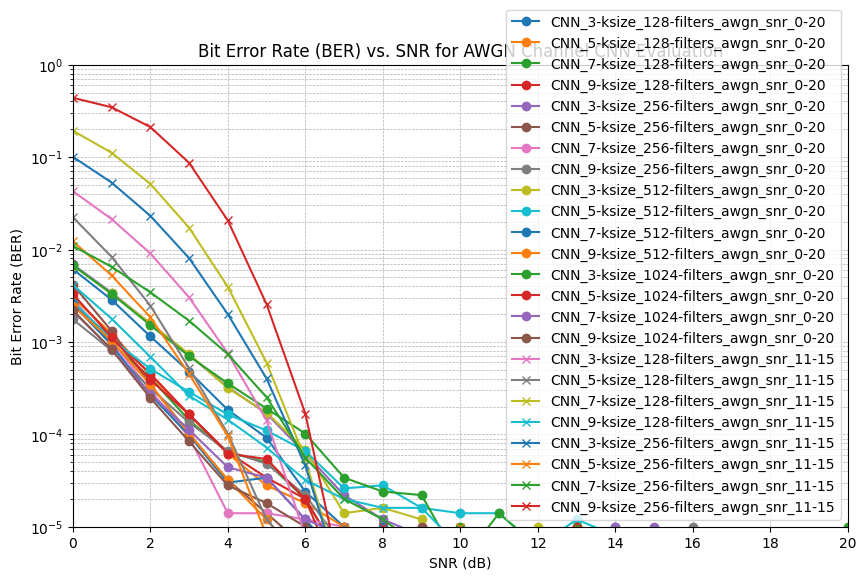

Grafico salvato come /content/drive/MyDrive/GitHub/AWGN/results/ber_cnn_all_models.png


In [11]:
# === Impostazioni di base ===
cnn_model_folder = "/content/drive/MyDrive/GitHub/AWGN/trained_models/cnn"
snr_test_data_path = "/content/drive/MyDrive/GitHub/AWGN/dataset/test"
results_folder = "/content/drive/MyDrive/GitHub/AWGN/results"

os.makedirs(results_folder, exist_ok=True)  # Crea la cartella dei risultati se non esiste

ber_results = {}
snr_points = None  # Verrà popolato durante il primo calcolo

for model_file in os.listdir(cnn_model_folder):
    if model_file.endswith(".h5"):
        model_name = model_file.replace(".h5", "")
        model_path = os.path.join(cnn_model_folder, model_file)
        result_file = os.path.join(results_folder, f"{model_name}_ber.npy")

        # Se esistono già i risultati, caricali
        if os.path.exists(result_file):
            print(f"Risultati già presenti per {model_name}, caricamento da file...")
            ber_values = np.load(result_file)
        else:
            print(f"\nCaricamento modello: {model_name}")
            model = load_model(model_path)
            ber_values, snr_points = calculate_ber(model, snr_test_data_path)
            np.save(result_file, ber_values)  # Salva risultati
            print(f"BER salvato in: {result_file}")

        ber_results[model_name] = ber_values
        print(f"BER per {model_name}: {ber_values}")

# === Plot finale ===
plot_ber(
    snr_points,
    ber_results,
    channel_type="AWGN",
    title_suffix="CNN Evaluation",
    filename=os.path.join(results_folder, "ber_cnn_all_models.png")
)
